# TP1 - Parte B: Classificação de Atividades Humanas 
### Tópicos de Ciência dos Dados - MECD (2022/2023)

### Autores

- Duarte Meneses - 2019216949
- Patricia Costa - 2019213995


In [1]:
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd

## 4.5 e 4.6 da Parte A

### 4.5. ReliefF

In [2]:
from ReliefF import ReliefF

def reliefF(x, y):
    fs = ReliefF(n_features_to_keep=10)
    fs.fit_transform(x, y)

    return fs.top_features[:10]

### 4.6. Fisher Score

In [3]:
from skfeature.function.similarity_based import fisher_score

def fisherScore(x, y):
    return fisher_score.fisher_score(x, y)

## Parte B


### 1.1. Data Splitting

### 1.1.1. Train-Test (TT) e Train-Validation-Test data split

In [4]:
from sklearn.model_selection import train_test_split
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

def train_test(data, target, train_size):

    x_train, x_test, y_train, y_test = train_test_split(data, target, train_size=train_size)

    trainTest = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]}

    return trainTest

def train_validation_test(data, target, train_size, test_size):

    x_train, x_rem, y_train, y_rem = train_test_split(data, target, train_size=train_size)

    # 1 - train_size -> correponde agora ao nosso 100%(1)
    # test_size -> test_size / (1-train_size)

    test = test_size / (1-train_size)

    x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = test)

    trainValidation = {"TRAIN": [x_train, y_train], "TEST": [x_test, y_test], "VALIDATION": [x_valid, y_valid]}
    
    return trainValidation



### 1.1.2. K-fold data split

In [5]:
from sklearn.model_selection import KFold
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html

def k_fold(x, y, n_splits):
    kf = KFold(n_splits=n_splits, shuffle = True)
    kfold = []
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        kfold.append({"TRAIN": [x_train, y_train], "TEST": [x_test, y_test]})
    
    return kfold

In [6]:
#Testes
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4])

print("--Train Test--\n")
trainTest = train_test(X, y, 0.7)
display(trainTest)

print("\n--Train Validation Test--\n")
trainValidation = train_validation_test(X, y, 0.4, 0.3)
display(trainValidation)

print("\n--K Fold--\n")
kFold = k_fold(X, y, 4)
display(kFold)

--Train Test--



{'TRAIN': [array([[1, 2],
         [3, 4]]),
  array([1, 2])],
 'TEST': [array([[3, 4],
         [1, 2]]),
  array([4, 3])]}


--Train Validation Test--



{'TRAIN': [array([[3, 4]]), array([4])],
 'TEST': [array([[1, 2],
         [1, 2]]), array([3, 1])],
 'VALIDATION': [array([[3, 4]]), array([2])]}


--K Fold--



[{'TRAIN': [array([[1, 2],
          [3, 4],
          [1, 2]]),
   array([1, 2, 3])],
  'TEST': [array([[3, 4]]), array([4])]},
 {'TRAIN': [array([[1, 2],
          [3, 4],
          [3, 4]]),
   array([1, 2, 4])],
  'TEST': [array([[1, 2]]), array([3])]},
 {'TRAIN': [array([[1, 2],
          [1, 2],
          [3, 4]]),
   array([1, 3, 4])],
  'TEST': [array([[3, 4]]), array([2])]},
 {'TRAIN': [array([[3, 4],
          [1, 2],
          [3, 4]]),
   array([2, 3, 4])],
  'TEST': [array([[1, 2]]), array([1])]}]

### 1.2. Métricas de exactidação

In [7]:
#Teste
true = [2, 0, 2, 2, 0, 1]
pred = [0, 0, 2, 2, 0, 2]

-> Explicação do parâmetro average

**'binary'**:
Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.

**'micro'**:
Calculate metrics globally by counting the total true positives, false negatives and false positives.

**'macro'**:
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

**'weighted'**:
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance; it can result in an F-score that is not between precision and recall.

**'samples'**:
Calculate metrics for each instance, and find their average (only meaningful for multilabel classification where this differs from accuracy_score).

,Metrics
Recall,0.666667
Precision,0.555556
F1-score,0.600000


,0,1,2
0,2,0,0
1,0,0,1
2,1,0,2


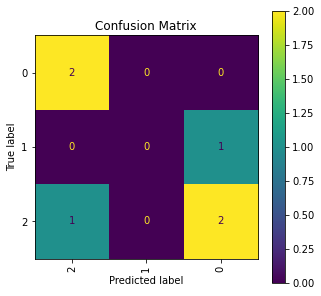

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
from sklearn.metrics import recall_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score
from sklearn.metrics import precision_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score
from sklearn.metrics import f1_score
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

def metrics(true, pred, printar = False):
    cm = confusion_matrix(true, pred)
    rs = recall_score(true, pred, average='weighted', zero_division=0)
    ps = precision_score(true, pred, average='weighted', zero_division=0)
    f1 = f1_score(true, pred, average='weighted', zero_division=0)

    if(printar):
        print('Confusion Matrix:\n', cm)
        print('\nRecall: ', rs)
        print('\nPrecision: ', ps)
        print('\nF1-score: ', f1)
        print('-'*50)

    return [cm, rs, ps, f1]

def mais_bonito(cm, rs, ps, f1, labels):

    metricsFrame = pd.DataFrame([rs, ps, f1], columns=['Metrics']).rename(index={0: 'Recall', 1: 'Precision', 2: 'F1-score'})
    display(metricsFrame)

    try:
        cmFrame = pd.DataFrame(cm, columns=labels, index=labels).style.set_caption("Confusion Matrix")
        display(cmFrame)

        cmp = ConfusionMatrixDisplay(cm, display_labels=labels)
        _, ax = plt.subplots(figsize=(5,5))
        cmp.plot(ax=ax)
        ax.set_title("Confusion Matrix")
        ax.xaxis.set_ticklabels(labels)
        ax.xaxis.set_ticklabels(labels[::-1], rotation=90)
        plt.show()

    except:
        cmFrame = pd.DataFrame(cm).style.set_caption("Confusion Matrix")
        display(cmFrame)

cm, rs, ps, f1 = metrics(true, pred)
mais_bonito(cm, rs, ps, f1, [0,1,2])



### 2.1. Dataset

In [9]:
iris = datasets.load_iris()

data = iris.data
target = iris.target

display(iris)

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

### 2.1. k-Nearest Neighbours

In [10]:
from sklearn.neighbors import KNeighborsClassifier

def K_neighbors_classifier(x, y, k):
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(x, y)

    return neigh


### 2.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


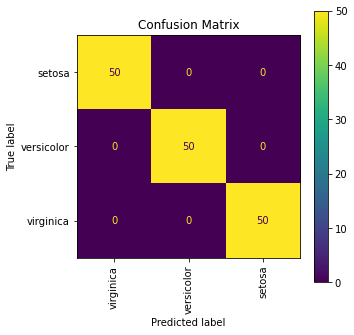

In [11]:
def TO_211(x, y, labels, k):
    neigh = K_neighbors_classifier(x, y, k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TO_211(data, target, iris["target_names"], 1)

### 2.1.1. TT 70-30

,Metrics
Recall,0.955556
Precision,0.960000
F1-score,0.955336


,setosa,versicolor,virginica
setosa,10,0,0
versicolor,0,15,2
virginica,0,0,18


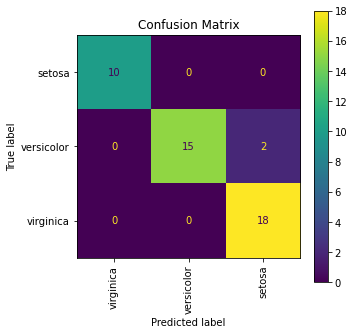

In [12]:
def TT_211(x, y, labels, k):
    trainTest = train_test(x, y, 0.7)
    neigh = K_neighbors_classifier(trainTest['TRAIN'][0], trainTest['TRAIN'][1], k)
    pred = neigh.predict(trainTest['TEST'][0])
    true = trainTest['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    
    mais_bonito(cm, rs, ps, f1, labels)

TT_211(data, target, iris["target_names"], 1)

### 2.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,5,0
virginica,0,0,5


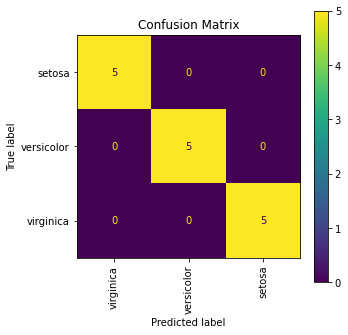

------------------- Iteração 1 -------------------


,Metrics
Recall,0.866667
Precision,0.866667
F1-score,0.866667


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,7,1
virginica,0,1,1


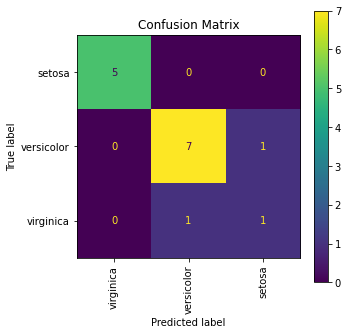

------------------- Iteração 2 -------------------


,Metrics
Recall,0.866667
Precision,0.866667
F1-score,0.866667


,setosa,versicolor,virginica
setosa,2,0,0
versicolor,0,5,1
virginica,0,1,6


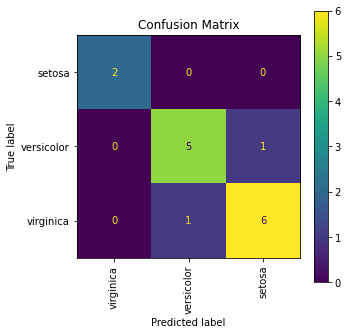

------------------- Iteração 3 -------------------


,Metrics
Recall,0.933333
Precision,0.950000
F1-score,0.935065


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,5,1
virginica,0,0,3


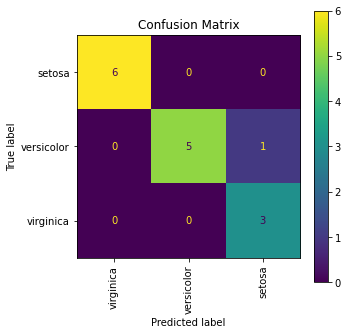

------------------- Iteração 4 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,7,0
virginica,0,0,4


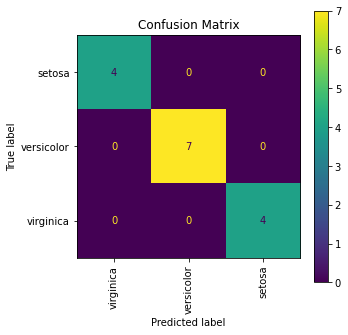

------------------- Iteração 5 -------------------


,Metrics
Recall,0.933333
Precision,0.955556
F1-score,0.937436


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,2,0
virginica,0,1,6


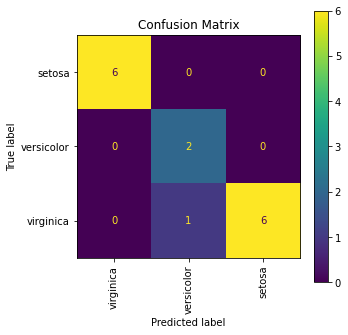

------------------- Iteração 6 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,3,0,0
versicolor,0,6,0
virginica,0,0,6


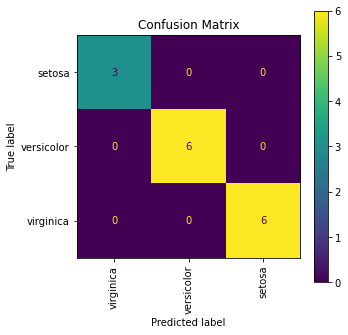

------------------- Iteração 7 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,0
virginica,0,0,5


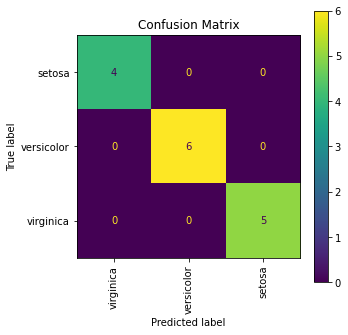

------------------- Iteração 8 -------------------


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,8,0,0
versicolor,0,1,0
virginica,0,0,6


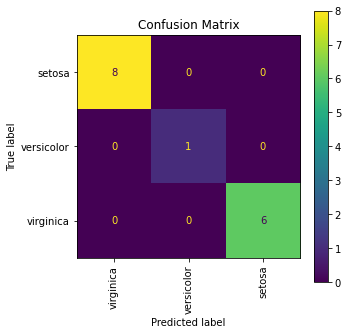

------------------- Iteração 9 -------------------


,Metrics
Recall,0.933333
Precision,0.950000
F1-score,0.934392


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,3,0
virginica,0,1,4


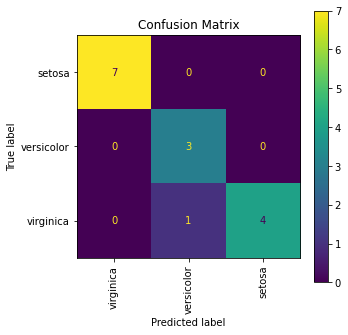

In [13]:
def CV_211(x, y, n_splits, labels, k):
    kf = k_fold(x, y, n_splits)

    count = 0
    for info in kf:
        print("------------------- Iteração " + str(count) + " -------------------")

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]

        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

        count += 1

CV_211(data, target, 10, iris["target_names"], 1)

### 2.1.2. k na gama {1, 3, 5, ...,15}

In [14]:
_k = np.arange(1, 16, 2)

display(_k)

array([ 1,  3,  5,  7,  9, 11, 13, 15])

### 2.1.2. Train-only

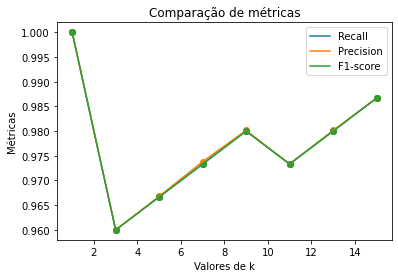

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,50,0,0
versicolor,0,50,0
virginica,0,0,50


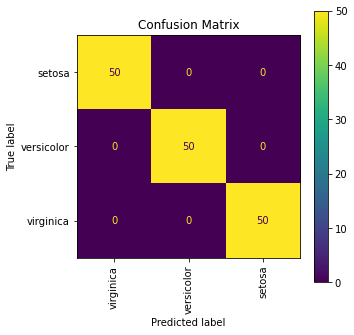

In [15]:
def TO_212(x, y, metr):
    for k in _k:
        neigh = K_neighbors_classifier(x, y, k)
        pred = neigh.predict(x)
        true = y
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TO_gama(x, y, labels):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TO_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    neigh = K_neighbors_classifier(x, y, best_k)
    pred = neigh.predict(x)
    true = y
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, labels)

TO_gama(data, target, iris["target_names"])

### 2.1.2. TVT 40-30-30

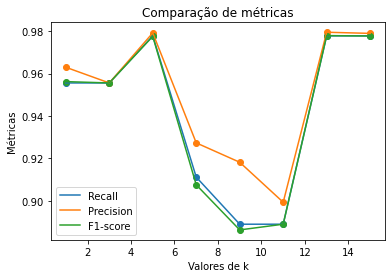

Best K: 13


,Metrics
Recall,0.933333
Precision,0.935445
F1-score,0.933714


,setosa,versicolor,virginica
setosa,15,0,0
versicolor,0,11,1
virginica,0,2,16


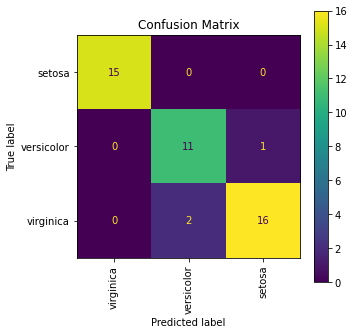

In [16]:
# TODO
# VER O MELHOR K -> FEITO
# PARA O MELHOR K, TESTAR COM O TREINO + VALIDATION JUNTOS, USANDO O TEST COMO PRED


def TVT_212(x, y, metr):
    for k in _k:
        trainValidation = train_validation_test(x, y, 0.4, 0.3)

        neigh = K_neighbors_classifier(trainValidation['TRAIN'][0], trainValidation['TRAIN'][1], k)
        pred = neigh.predict(trainValidation['VALIDATION'][0])
        true = trainValidation['VALIDATION'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)
    
    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def TVT_gama(x, y, labels):
    metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
    
    new_metr = TVT_212(x, y, metr)

    plot_metricas(new_metr)

    pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
    best_k = _k[pos_k]
    print("Best K: " + str(best_k))

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    newTrain0 = np.concatenate((trainValidation['TRAIN'][0], trainValidation['VALIDATION'][0]), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    pred = neigh.predict(trainValidation['TEST'][0])
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    mais_bonito(cm, rs, ps, f1, labels)

TVT_gama(data, target, iris["target_names"])

### 2.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


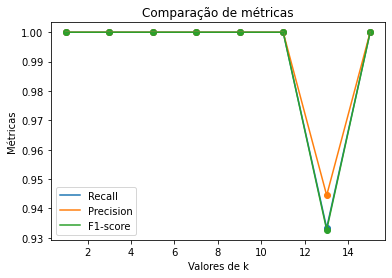

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,5,0
virginica,0,0,5


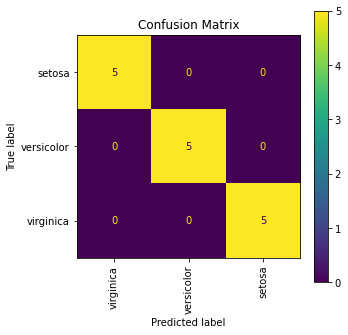

------------------- Iteração 1 -------------------


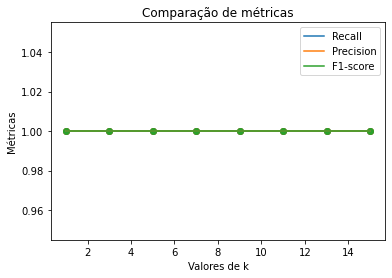

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,6,0
virginica,0,0,5


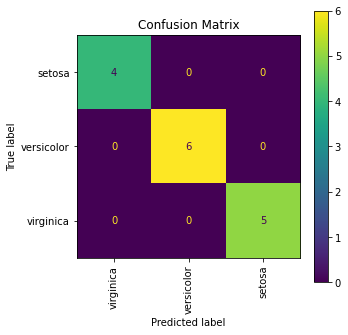

------------------- Iteração 2 -------------------


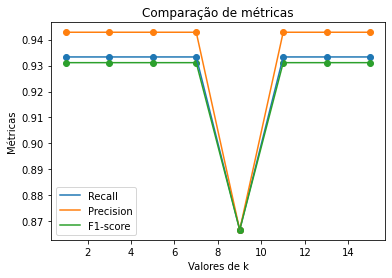

Best K: 1


,Metrics
Recall,0.933333
Precision,0.942857
F1-score,0.931136


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,3,1
virginica,0,0,6


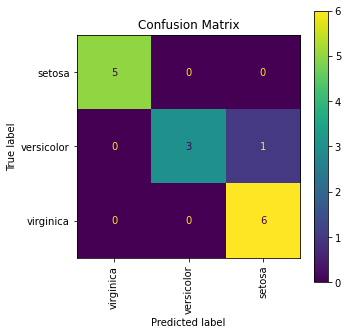

------------------- Iteração 3 -------------------


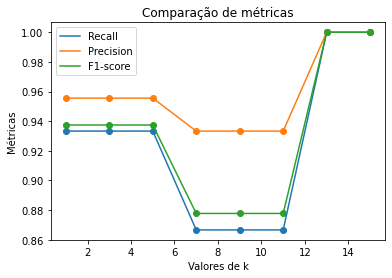

Best K: 13


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,2,0
virginica,0,0,7


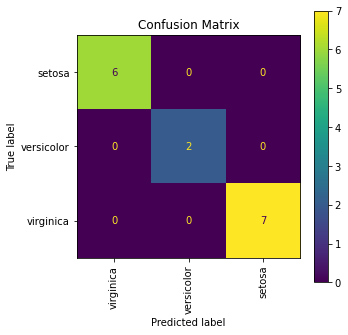

------------------- Iteração 4 -------------------


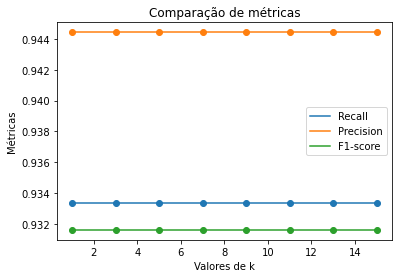

Best K: 1


,Metrics
Recall,0.933333
Precision,0.944444
F1-score,0.931602


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,3,1
virginica,0,0,5


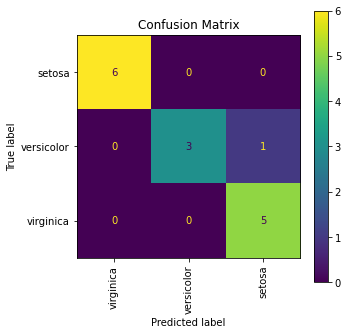

------------------- Iteração 5 -------------------


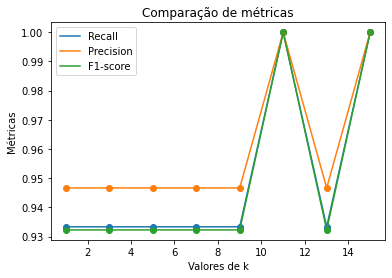

Best K: 11


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,7,0,0
versicolor,0,4,0
virginica,0,0,4


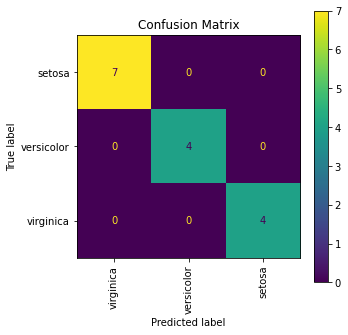

------------------- Iteração 6 -------------------


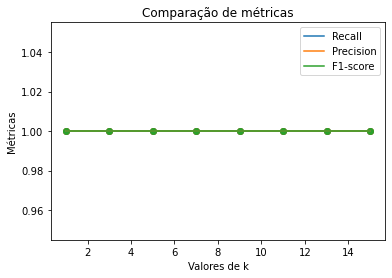

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,4,0,0
versicolor,0,5,0
virginica,0,0,6


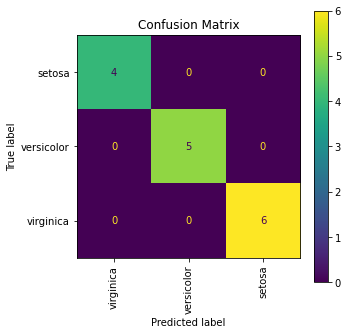

------------------- Iteração 7 -------------------


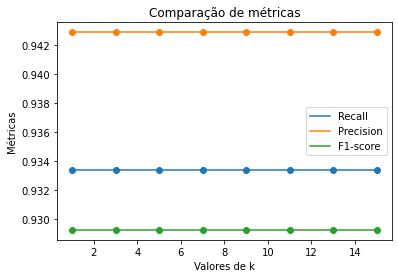

Best K: 1


,Metrics
Recall,0.933333
Precision,0.942857
F1-score,0.929231


,setosa,versicolor,virginica
setosa,6,0,0
versicolor,0,6,0
virginica,0,1,2


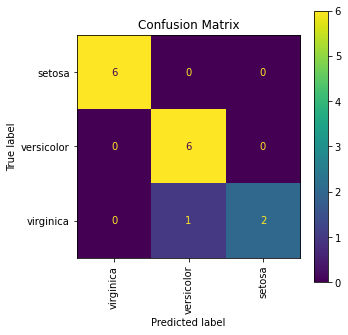

------------------- Iteração 8 -------------------


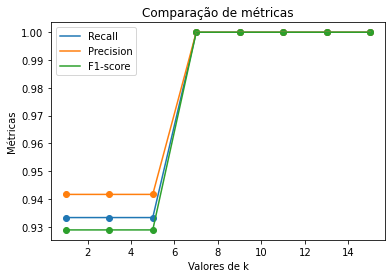

Best K: 7


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,5,0,0
versicolor,0,7,0
virginica,0,0,3


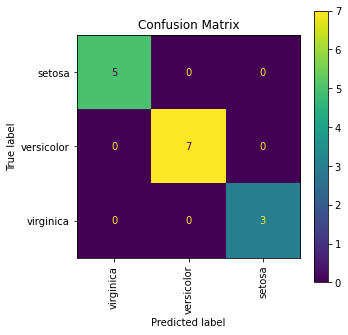

------------------- Iteração 9 -------------------


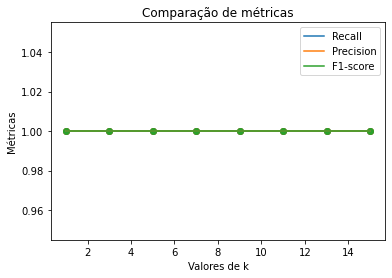

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,setosa,versicolor,virginica
setosa,2,0,0
versicolor,0,7,0
virginica,0,0,6


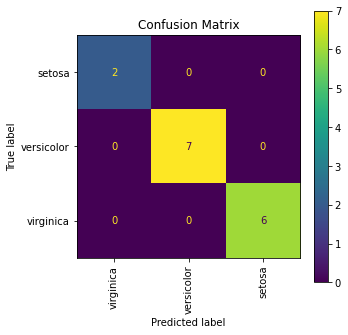

In [17]:
def CV_212(info, metr):
    for k in _k:
        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        metr["Neigh"].append(neigh)
        metr["Recall"].append(rs)
        metr["Precision"].append(ps)
        metr["F1-score"].append(f1)

    return metr

def plot_metricas(metr):
    plt.figure()

    plt.plot(_k, metr["Recall"], label="Recall")
    plt.scatter(_k, metr["Recall"])
    plt.plot(_k, metr["Precision"], label="Precision")
    plt.scatter(_k, metr["Precision"])
    plt.plot(_k, metr["F1-score"], label="F1-score")
    plt.scatter(_k, metr["F1-score"])
    
    plt.title("Comparação de métricas")
    plt.xlabel("Valores de k")
    plt.ylabel("Métricas")
    plt.legend()
    plt.show()

def CV_gama(x, y, labels):
    
    kf = k_fold(x, y, 10)
    count = 0
    for info in kf:
        metr = {"Neigh": [], "Recall": [], "Precision": [], "F1-score": []}
        print("------------------- Iteração " + str(count) + " -------------------")
        count += 1
        new_metr = CV_212(info, metr)

        plot_metricas(new_metr)

        pos_k = new_metr["F1-score"].index(max(new_metr["F1-score"]))
        best_k = _k[pos_k]
        print("Best K: " + str(best_k))

        neigh = K_neighbors_classifier(info['TRAIN'][0], info['TRAIN'][1], best_k)
        pred = neigh.predict(info['TEST'][0])
        true = info['TEST'][1]
        cm, rs, ps, f1 = metrics(true, pred)

        mais_bonito(cm, rs, ps, f1, labels)

CV_gama(data, target, iris["target_names"])

### 2.2. ReliefF

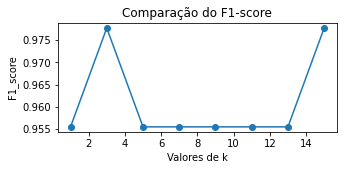

Nr of features: 1
Best K: 3
F1_score: 0.9109259259259259
--------------------------------------------------


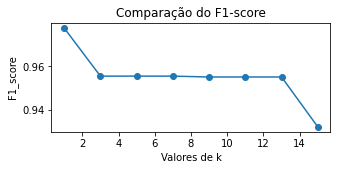

Nr of features: 2
Best K: 1
F1_score: 0.9105508870214751
--------------------------------------------------


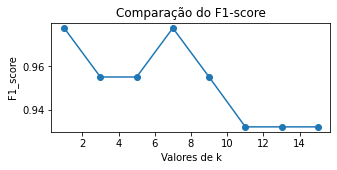

Nr of features: 3
Best K: 1
F1_score: 0.9555555555555556
--------------------------------------------------


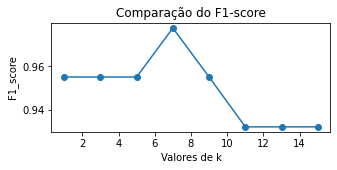

Nr of features: 4
Best K: 7
F1_score: 0.9554629629629631
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.955556,0.977703,0.955556,0.955556,0.955556,0.955556,0.955556,0.977703
Nº of features: 2,0.977703,0.955556,0.955556,0.955556,0.955153,0.955153,0.955153,0.932190
Nº of features: 3,0.977703,0.955153,0.955153,0.977703,0.955153,0.932190,0.932190,0.932190
Nº of features: 4,0.955153,0.955153,0.955153,0.977703,0.955153,0.932190,0.932190,0.932190


In [18]:
def plot_f1(metr_f1):
    plt.figure(figsize=(5,2))

    plt.plot(_k, metr_f1["F1-score"])
    plt.scatter(_k, metr_f1["F1-score"])
    
    plt.title("Comparação do F1-score")
    plt.xlabel("Valores de k")
    plt.ylabel("F1_score")
    plt.show()

def bestkTVT(metr, feat, xTrain, xValidation, trainValidation, s):
    s += 'Nr of features: ' + str(len(feat)) + '\n'
    print('Nr of features: ' + str(len(feat)))
    pos_k = metr["F1-score"].index(max(metr["F1-score"]))
    best_k = _k[pos_k]
    s += "Best K: " + str(best_k) + '\n'
    print("Best K: " + str(best_k))

    newTrain0 = np.concatenate((xTrain, xValidation), axis=0)
    newTrain1 = np.concatenate((trainValidation['TRAIN'][1], trainValidation['VALIDATION'][1]), axis=0)

    neigh = K_neighbors_classifier(newTrain0, newTrain1, best_k)
    xTest = trainValidation['TEST'][0][:,feat]
    pred = neigh.predict(xTest)
    true = trainValidation['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)

    s += 'F1_score: ' + str(f1) + '\n' + '-'*50 + '\n'
    print('F1_score: ' + str(f1))
    print('-'*50)

    return f1, s

def repeatTVT(x, y, featselec, num = 4):

    trainValidation = train_validation_test(x, y, 0.4, 0.3)

    f1_score = []
    f1_score_elbow = []
    str_print = ''

    for f in range(num):
        metr = {"F1-score": []}
        feat = featselec[:(f+1)]
        xTrain = trainValidation['TRAIN'][0][:,feat]
        xValidation = trainValidation['VALIDATION'][0][:,feat]

        for k in _k:
            neigh = K_neighbors_classifier(xTrain, trainValidation['TRAIN'][1], k)
            pred = neigh.predict(xValidation)
            true = trainValidation['VALIDATION'][1]
            cm, rs, ps, f1 = metrics(true, pred)

            metr["F1-score"].append(f1)
        f1_score.append(metr["F1-score"])

        #------------Plot F1-Score--------------------------
        plot_f1(metr)

        #------------Best k--------------------------
        aux, str_print = bestkTVT(metr, feat, xTrain, xValidation, trainValidation, str_print)
        f1_score_elbow.append(aux)

    label = ['Nº of features: ' + str(i+1) for i in range(len(featselec))]
    col = ['k=' + str(i) for i in _k]
    df = pd.DataFrame(f1_score, columns = col, index = label)
    display(df)

    return f1_score_elbow, df, str_print
        

f1_score_elbow, df223, str_print = repeatTVT(data, target, reliefF(data, target))

### 2.2.2 Elbow graph

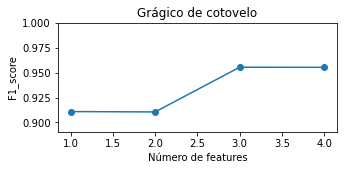

In [19]:
def elbowGraph(lista_f1, num):
    index = np.arange(1,num)

    plt.figure(figsize=(5,2))
    plt.ylim(min(lista_f1)-0.02,1)

    plt.plot(index, lista_f1)
    plt.scatter(index, lista_f1)
    
    plt.title("Grágico de cotovelo")
    plt.xlabel("Número de features")
    plt.ylabel("F1_score")
    plt.show()

elbowGraph(f1_score_elbow, 5)

### 2.2.3. Validation set results

In [20]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.955556,0.977703,0.955556,0.955556,0.955556,0.955556,0.955556,0.977703
Nº of features: 2,0.977703,0.955556,0.955556,0.955556,0.955153,0.955153,0.955153,0.932190
Nº of features: 3,0.977703,0.955153,0.955153,0.977703,0.955153,0.932190,0.932190,0.932190
Nº of features: 4,0.955153,0.955153,0.955153,0.977703,0.955153,0.932190,0.932190,0.932190


### 2.2.4. Test set results

In [21]:
print(str_print)

Nr of features: 1
Best K: 3
F1_score: 0.9109259259259259
--------------------------------------------------
Nr of features: 2
Best K: 1
F1_score: 0.9105508870214751
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.9555555555555556
--------------------------------------------------
Nr of features: 4
Best K: 7
F1_score: 0.9554629629629631
--------------------------------------------------



### 2.3. Fisher Score

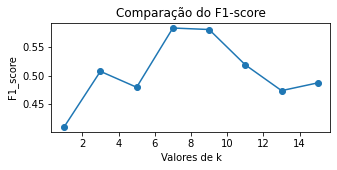

Nr of features: 1
Best K: 7
F1_score: 0.5466953021132587
--------------------------------------------------


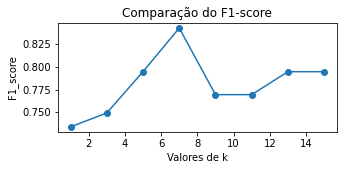

Nr of features: 2
Best K: 7
F1_score: 0.7317460317460318
--------------------------------------------------


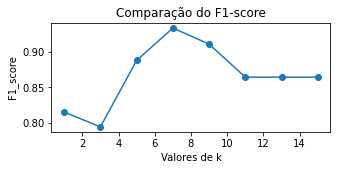

Nr of features: 3
Best K: 7
F1_score: 0.9105820105820105
--------------------------------------------------


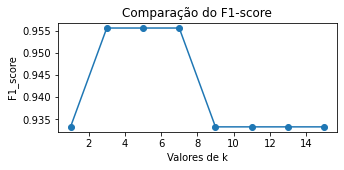

Nr of features: 4
Best K: 3
F1_score: 0.9332345679012346
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.410066,0.507627,0.479645,0.583740,0.581121,0.518970,0.473715,0.487374
Nº of features: 2,0.733824,0.749177,0.794781,0.843011,0.769424,0.769424,0.794781,0.794781
Nº of features: 3,0.815539,0.794781,0.887865,0.933333,0.910784,0.864444,0.864444,0.864444
Nº of features: 4,0.933333,0.955637,0.955637,0.955637,0.933333,0.933333,0.933333,0.933333


In [22]:
score = fisherScore(data, target)

f1_score_elbow, df223, str_print = repeatTVT(data, target, score)


### 2.3.2. Elbow Graph

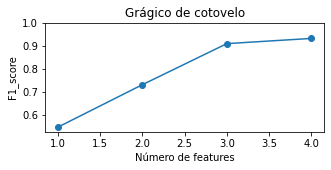

In [23]:
elbowGraph(f1_score_elbow, 5)

### 2.3.3. Validation set results

In [24]:
display(df223)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.410066,0.507627,0.479645,0.583740,0.581121,0.518970,0.473715,0.487374
Nº of features: 2,0.733824,0.749177,0.794781,0.843011,0.769424,0.769424,0.794781,0.794781
Nº of features: 3,0.815539,0.794781,0.887865,0.933333,0.910784,0.864444,0.864444,0.864444
Nº of features: 4,0.933333,0.955637,0.955637,0.955637,0.933333,0.933333,0.933333,0.933333


### 2.3.4. Test set results

In [25]:
print(str_print)

Nr of features: 1
Best K: 7
F1_score: 0.5466953021132587
--------------------------------------------------
Nr of features: 2
Best K: 7
F1_score: 0.7317460317460318
--------------------------------------------------
Nr of features: 3
Best K: 7
F1_score: 0.9105820105820105
--------------------------------------------------
Nr of features: 4
Best K: 3
F1_score: 0.9332345679012346
--------------------------------------------------



### 2.4. Class imbalance

 'target_names': array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [26]:
irisDF = pd.DataFrame(iris.data, columns=iris["feature_names"])
irisDF["target"] = iris["target"]
setosa = irisDF[irisDF["target"] == 0]
versicolor = irisDF[irisDF["target"] == 1].sample(30)
virginica = irisDF[irisDF["target"] == 2].sample(10)
new_iris = pd.concat([setosa, versicolor, virginica], axis=0)
new_iris.groupby("target").count()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
target,,,,
0,50,50,50,50
1,30,30,30,30
2,10,10,10,10


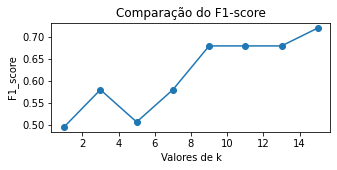

Nr of features: 1
Best K: 15
F1_score: 0.7892131763099505
--------------------------------------------------


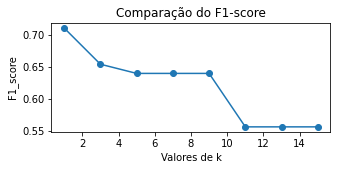

Nr of features: 2
Best K: 1
F1_score: 0.8732943469785576
--------------------------------------------------


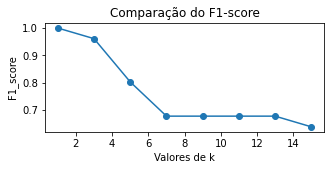

Nr of features: 3
Best K: 1
F1_score: 0.8732943469785576
--------------------------------------------------


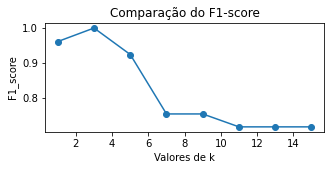

Nr of features: 4
Best K: 3
F1_score: 0.9259259259259259
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.495096,0.579606,0.506173,0.579606,0.679270,0.679270,0.679270,0.720000
Nº of features: 2,0.710562,0.653895,0.639506,0.639506,0.639506,0.555813,0.555813,0.555813
Nº of features: 3,1.000000,0.961199,0.803343,0.678587,0.678587,0.678587,0.678587,0.639506
Nº of features: 4,0.961199,1.000000,0.923966,0.753504,0.753504,0.716450,0.716450,0.716450


In [27]:
aux_data = np.array(new_iris.drop(columns=["target"]))
aux_target = np.array(new_iris["target"])

score = fisherScore(aux_data, aux_target)

newIris_elbow, df224, str_print = repeatTVT(aux_data, aux_target, score)

### 2.4.2. Elbow Graph

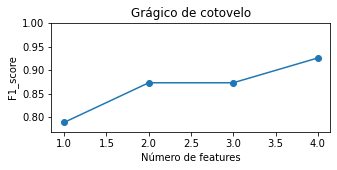

In [28]:
elbowGraph(newIris_elbow, 5)

### 2.4.3. Validation set results

In [29]:
display(df224)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.495096,0.579606,0.506173,0.579606,0.679270,0.679270,0.679270,0.720000
Nº of features: 2,0.710562,0.653895,0.639506,0.639506,0.639506,0.555813,0.555813,0.555813
Nº of features: 3,1.000000,0.961199,0.803343,0.678587,0.678587,0.678587,0.678587,0.639506
Nº of features: 4,0.961199,1.000000,0.923966,0.753504,0.753504,0.716450,0.716450,0.716450


### 2.4.4. Test set results

In [30]:
print(str_print)

Nr of features: 1
Best K: 15
F1_score: 0.7892131763099505
--------------------------------------------------
Nr of features: 2
Best K: 1
F1_score: 0.8732943469785576
--------------------------------------------------
Nr of features: 3
Best K: 1
F1_score: 0.8732943469785576
--------------------------------------------------
Nr of features: 4
Best K: 3
F1_score: 0.9259259259259259
--------------------------------------------------



### 3. ReliefF for dataset of human activity

In [31]:
activities = np.array(['Stand', 'Sit', 'Sit and Talk', 'Walk', 'Walk and Talk', 'Climb Stair (up/down)',
    'Climb Stair (up/down) and talk', 'Stand -> Sit', 'Sit -> Stand', 'Stand -> Sit and talk', 'Sit -> Stand and talk',
    'Stand -> walk', 'Walk -> stand', 'Stand -> climb stairs (up/down)(and talk)', 'Climb stairs (up/down) -> walk',
    'Climb stairs (up/down) and talk -> walk and talk'])
    
Acc_features = pd.read_csv("dataset/Acc_features.csv").drop(columns='Unnamed: 0')
Gyr_features = pd.read_csv("dataset/Gyr_features.csv").drop(columns=['Unnamed: 0','Label'])
Mag_features = pd.read_csv("dataset/Mag_features.csv").drop(columns=['Unnamed: 0', 'Label'])

new_data = pd.concat([Acc_features, Gyr_features, Mag_features], axis=1)
new_data.to_csv('features.csv', encoding='utf-8')
display(new_data)

new_target = np.array(new_data["Label"])
feature_data = np.array(new_data.drop(columns = ["Label"]))

,Label,Acc X Mean,Acc X Median,Acc X Std,Acc X Variance,Acc X RMS,Acc X AD,Acc X Skew,Acc X Kurtosis,Acc X IQR,...,Mag Z acc Z Corr,Mag X gyr X Corr,Mag X gyr Y Corr,Mag X gyr Z Corr,Mag Y gyr X Corr,Mag Y gyr Y Corr,Mag Y gyr Z Corr,Mag Z gyr X Corr,Mag Z gyr Y Corr,Mag Z gyr Z Corr
0,Stand,2.816928,2.81290,0.081657,0.006668,2.818100,-0.000820,0.104070,0.486731,0.084675,...,0.538935,0.288415,-0.039466,-0.261845,0.319700,-0.137996,-0.320163,-0.608719,0.247963,0.599854
1,Stand,2.864813,2.86200,0.088376,0.007810,2.866162,0.001941,-0.237104,-0.098164,0.135050,...,0.844737,-0.477185,-0.213984,0.385307,-0.190807,-0.281080,0.065046,0.434173,0.272281,-0.243218
2,Stand,2.646591,2.80950,0.347139,0.120506,2.669039,-0.011722,-0.984057,-0.323593,0.464225,...,-0.773026,-0.399344,-0.234917,0.380753,0.428215,0.272995,-0.462982,0.414267,0.233638,-0.398286
3,Stand,2.212950,2.09150,0.285796,0.081679,2.231149,-0.008253,0.830326,-0.620484,0.455650,...,-0.662408,0.547276,0.405573,-0.486648,-0.267835,-0.202777,0.193784,-0.513572,-0.399738,0.459841
4,Stand,2.058188,2.05515,0.102485,0.010503,2.060713,0.001548,0.153356,0.366587,0.133325,...,0.120578,-0.024781,-0.101842,-0.099390,-0.099077,-0.049309,-0.077035,0.184977,0.288267,0.136665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14483,Climb stairs (up/down) and talk -> walk and talk,-2.100210,-2.19370,0.641578,0.411623,2.195101,-0.003014,0.470363,-0.706343,0.992650,...,-0.018973,0.118220,0.258170,-0.052384,0.068988,0.407538,0.036470,0.223724,-0.114251,0.030868
14484,Climb stairs (up/down) and talk -> walk and talk,3.425963,4.08130,1.693263,2.867140,3.817886,-0.035674,-1.723238,2.626517,1.417625,...,-0.726469,-0.551289,0.193614,0.176818,-0.063941,-0.482605,-0.523068,0.652333,-0.212316,-0.115947
14485,Climb stairs (up/down) and talk -> walk and talk,2.307871,2.18690,1.030087,1.061080,2.525261,0.024127,0.010703,0.621858,0.955350,...,0.189340,-0.394748,-0.056330,0.030090,0.067419,0.096801,0.058462,0.371020,0.462721,0.366293
14486,Climb stairs (up/down) and talk -> walk and talk,1.404052,1.36710,0.719179,0.517218,1.575915,0.010513,-0.280569,0.222744,0.997815,...,0.072190,0.190854,0.447516,0.256721,0.279052,0.443746,0.507358,-0.002371,-0.630569,-0.392307


### 3.1.1. Train-only

,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,1724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit,0,830,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit and Talk,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,1620,0,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,0,0,0,1561,0,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,0,2917,0,0,0,0,0,0,0
Stand -> Sit and talk,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0


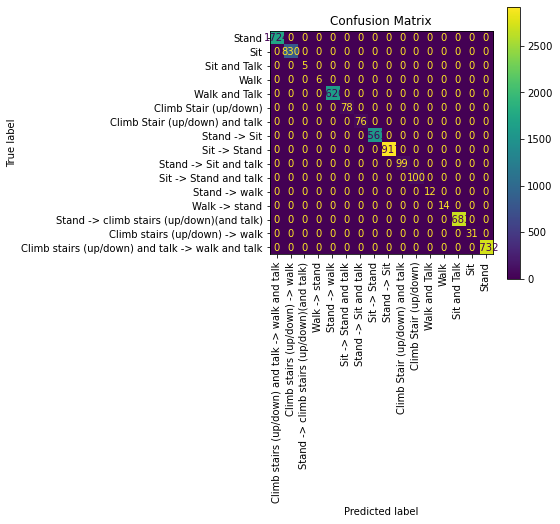

In [32]:
TO_211(feature_data, new_target, activities, 1)

### 3.1.1. TT 70-30

,Metrics
Recall,0.537842
Precision,0.536884
F1-score,0.537048


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,158,59,1,1,0,0,1,0,2,0,1,0,0,128,0,126
Sit,71,29,1,0,0,1,2,0,0,1,1,0,0,67,0,72
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk and Talk,0,0,0,0,327,1,0,135,0,6,3,0,0,0,0,0
Climb Stair (up/down),5,1,0,0,2,3,2,0,9,0,3,0,0,3,0,2
Climb Stair (up/down) and talk,2,0,0,0,0,2,2,0,5,1,1,0,0,3,1,1
Stand -> Sit,0,0,0,0,107,2,4,344,2,2,7,0,0,1,0,0
Sit -> Stand,2,1,0,0,0,17,6,2,857,1,1,0,0,13,4,12
Stand -> Sit and talk,1,1,0,0,5,0,1,6,2,4,7,0,1,4,0,2


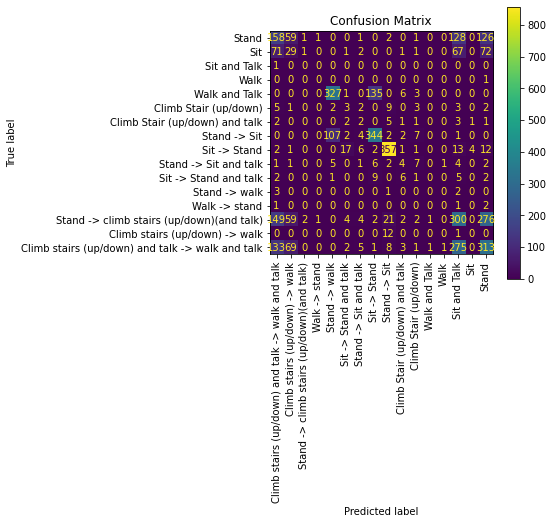

In [33]:
TT_211(feature_data, new_target, activities, 1)

### 3.1.1. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


,Metrics
Recall,0.544513
Precision,0.545872
F1-score,0.544305


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,53,30,0,0,0,0,0,0,0,0,0,0,49,0,45
1,17,12,3,0,0,0,0,0,0,0,1,0,15,0,30
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,117,0,0,51,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0
5,2,0,0,0,0,1,1,3,0,1,0,0,1,1,1
6,0,0,0,33,0,0,115,0,1,0,0,0,0,0,1
7,0,0,0,0,4,1,1,277,0,1,0,0,4,2,2
8,1,0,0,4,0,2,1,0,1,1,0,0,0,0,0
9,0,0,0,0,1,0,2,2,2,2,0,1,0,0,1


------------------- Iteração 1 -------------------


,Metrics
Recall,0.541063
Precision,0.536764
F1-score,0.538586


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,55,18,0,0,0,0,2,0,1,0,1,2,0,36,0,47
Sit,21,9,0,0,0,1,0,0,1,0,0,1,1,27,0,22
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,102,0,0,39,0,0,1,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,1,0,0,4,1,0,0,0,2,0,0
Climb Stair (up/down) and talk,0,1,0,0,0,1,0,0,4,0,0,0,0,1,0,2
Stand -> Sit,0,0,0,0,39,0,0,118,1,0,0,0,0,2,0,1
Sit -> Stand,3,0,0,0,0,1,1,0,280,1,1,0,0,7,2,6
Stand -> Sit and talk,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,2


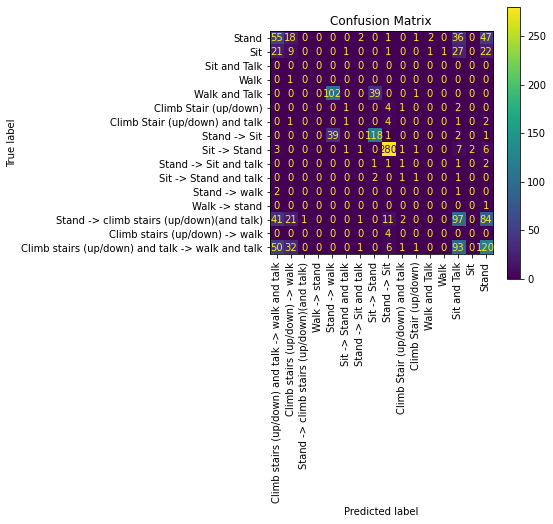

------------------- Iteração 2 -------------------


,Metrics
Recall,0.543133
Precision,0.543133
F1-score,0.542503


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,60,22,1,0,0,1,0,0,0,2,0,1,0,36,0,53
Sit,26,9,0,0,0,0,0,0,0,1,0,0,0,16,0,27
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk and Talk,0,0,0,0,123,0,0,52,0,0,0,0,0,0,0,0
Climb Stair (up/down),2,0,0,0,0,1,0,0,3,0,0,0,0,2,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,0,0,6,0,0,0,0,1,0,0
Stand -> Sit,0,0,0,0,38,0,0,131,0,0,3,0,0,1,0,0
Sit -> Stand,2,0,0,0,0,3,4,0,271,1,0,0,0,7,5,6
Stand -> Sit and talk,0,1,0,0,0,1,0,3,0,1,1,0,0,1,0,1


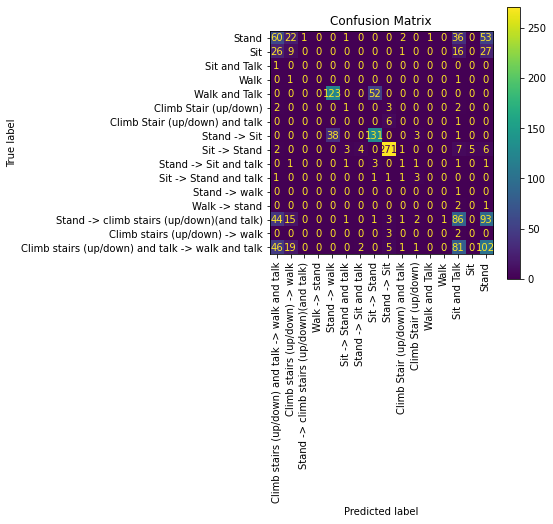

------------------- Iteração 3 -------------------


,Metrics
Recall,0.553485
Precision,0.553218
F1-score,0.552943


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,71,22,0,0,0,0,0,0,1,1,0,0,1,60,0,36
Sit,18,9,0,0,0,0,0,0,0,1,0,0,0,20,0,15
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk and Talk,0,0,0,0,119,0,0,42,0,1,2,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,2,2,0,3,1,0,0,0,1,0,0
Climb Stair (up/down) and talk,1,0,0,0,0,1,1,0,5,0,0,0,0,0,0,2
Stand -> Sit,0,0,0,0,37,0,0,112,1,1,3,0,0,0,0,0
Sit -> Stand,2,1,0,0,0,2,4,2,267,0,0,0,0,5,2,3
Stand -> Sit and talk,0,0,0,0,0,1,0,3,2,0,1,0,0,1,0,2


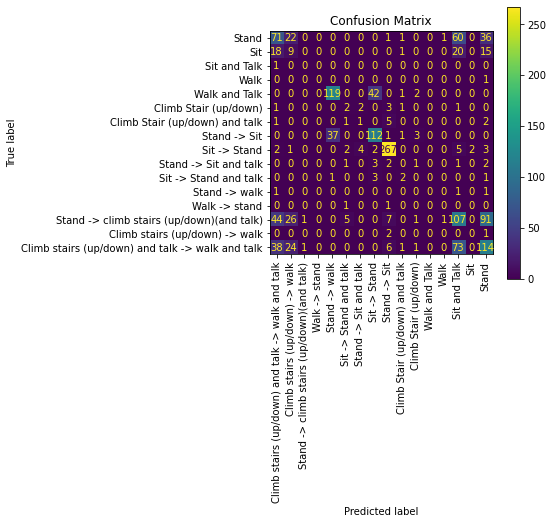

------------------- Iteração 4 -------------------


,Metrics
Recall,0.548654
Precision,0.539373
F1-score,0.542574


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,53,19,1,1,0,0,0,0,0,1,0,0,46,0,42
1,30,8,0,0,0,0,0,0,1,0,0,0,36,0,22
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,110,0,1,59,0,1,2,0,0,0,0
5,1,0,0,0,0,0,0,0,6,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
7,0,0,0,0,39,1,0,114,1,0,1,0,0,0,0
8,0,0,0,0,0,3,2,0,280,0,0,0,2,3,3
9,1,0,0,0,1,0,0,1,0,2,1,0,0,0,0


------------------- Iteração 5 -------------------


,Metrics
Recall,0.530021
Precision,0.535171
F1-score,0.532015


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,55,22,0,0,0,0,0,0,1,0,1,1,0,52,0,42
Sit,17,15,0,0,0,0,0,0,0,0,0,0,0,24,0,24
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,113,0,0,44,1,0,1,0,0,0,0,0
Climb Stair (up/down),0,2,0,0,0,0,3,1,3,1,0,0,0,1,0,1
Climb Stair (up/down) and talk,1,1,0,0,0,1,0,0,3,2,0,0,0,2,0,1
Stand -> Sit,1,0,0,0,37,0,1,102,0,1,0,0,0,0,0,0
Sit -> Stand,2,0,0,0,0,3,6,0,280,0,1,0,0,8,1,5
Stand -> Sit and talk,0,0,0,0,1,0,0,2,0,3,2,0,1,0,0,1


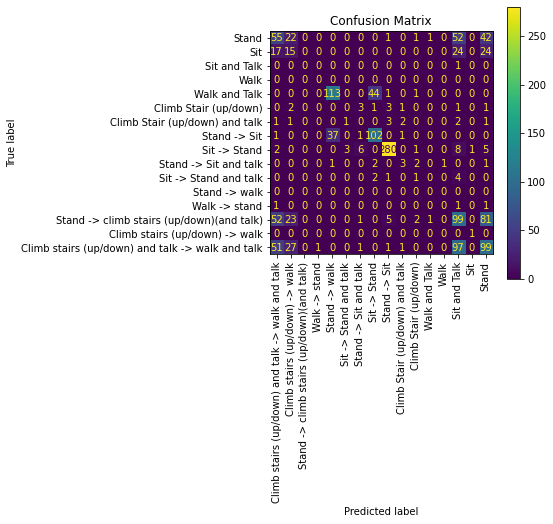

------------------- Iteração 6 -------------------


,Metrics
Recall,0.537612
Precision,0.536250
F1-score,0.535721


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,69,21,0,1,0,1,0,0,1,0,0,0,1,47,0,38
Sit,20,12,0,0,0,0,0,0,0,0,1,0,0,21,0,28
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,99,0,0,46,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,1,0,0,3,0,1,0,0,1,0,1
Climb Stair (up/down) and talk,1,0,0,0,0,1,0,0,3,0,0,0,0,1,0,0
Stand -> Sit,0,0,0,0,33,0,0,99,1,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,3,3,0,297,1,0,0,0,6,4,2
Stand -> Sit and talk,0,1,0,0,3,1,0,3,1,1,0,0,0,1,0,1


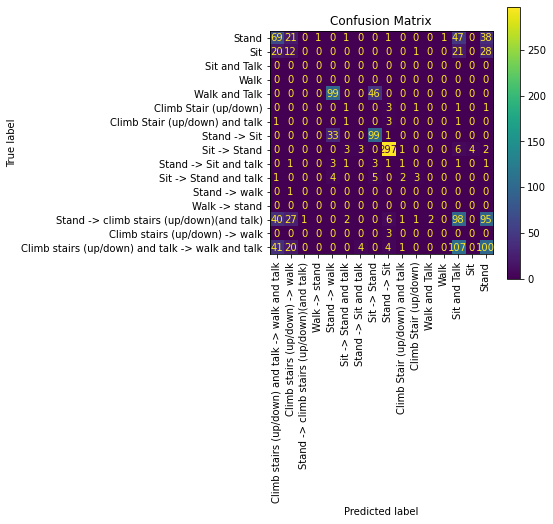

------------------- Iteração 7 -------------------


,Metrics
Recall,0.528640
Precision,0.526952
F1-score,0.526372


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,64,22,1,0,0,1,0,0,1,0,2,0,0,45,0,38
Sit,25,11,0,0,0,0,0,0,1,0,0,0,0,20,0,17
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,126,0,0,55,0,1,1,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,1,0,0,3,0,0,0,0,1,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,1,0,3,1,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,38,0,1,129,3,1,0,0,0,0,0,0
Sit -> Stand,0,1,0,0,0,5,1,1,226,0,0,0,0,4,0,3
Stand -> Sit and talk,0,2,0,0,1,0,1,3,0,2,1,0,0,2,0,0


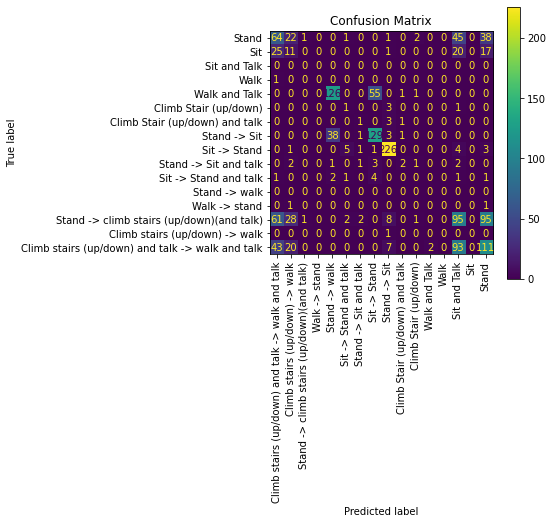

------------------- Iteração 8 -------------------


,Metrics
Recall,0.542127
Precision,0.541787
F1-score,0.541472


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,53,13,1,1,0,0,2,0,0,0,0,0,0,48,0,41
Sit,27,13,1,0,0,0,1,0,0,1,0,0,0,26,0,24
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk and Talk,0,0,0,0,98,0,0,49,0,2,0,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,0,0,0,4,0,1,0,0,1,0,1
Climb Stair (up/down) and talk,0,0,0,0,0,2,0,0,2,0,0,0,0,1,1,3
Stand -> Sit,0,0,0,0,33,0,0,126,1,1,4,0,0,0,0,0
Sit -> Stand,0,1,0,0,1,7,3,1,278,0,1,0,0,4,4,3
Stand -> Sit and talk,0,1,0,0,3,0,1,1,1,0,0,0,0,3,0,1


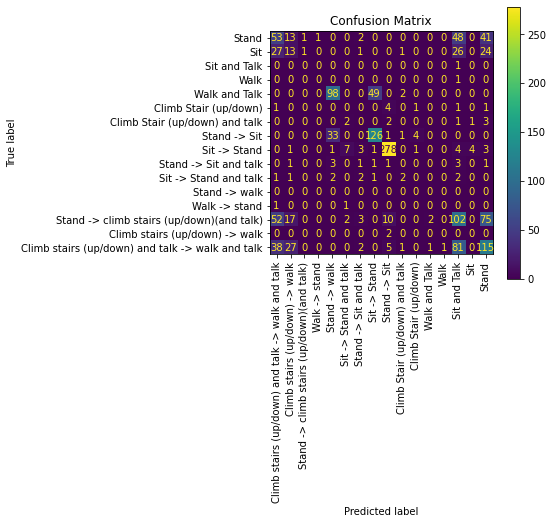

------------------- Iteração 9 -------------------


,Metrics
Recall,0.565608
Precision,0.562341
F1-score,0.563449


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,59,21,0,0,0,0,0,0,0,0,1,0,1,35,0,51
Sit,22,12,0,0,0,0,0,0,0,0,0,0,0,32,0,35
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,128,0,0,30,0,2,1,0,0,0,0,0
Climb Stair (up/down),0,1,0,0,0,2,1,0,4,0,1,0,0,0,0,0
Climb Stair (up/down) and talk,2,1,0,0,0,0,0,0,2,0,0,0,0,1,0,0
Stand -> Sit,0,0,0,0,29,0,1,121,1,1,2,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,5,4,0,262,0,1,0,0,2,3,0
Stand -> Sit and talk,1,0,0,0,1,0,0,4,0,2,2,0,0,2,0,1


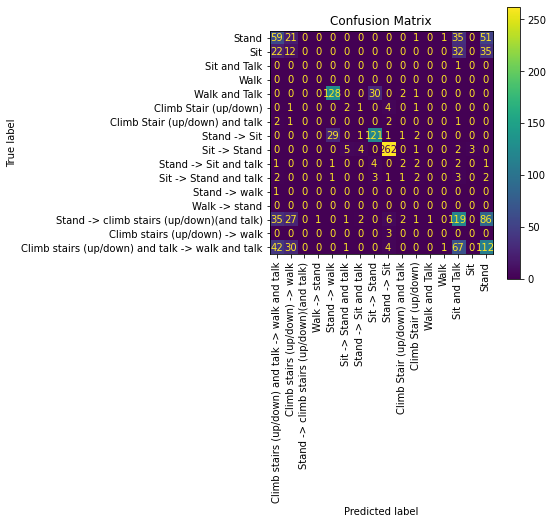

In [34]:
CV_211(feature_data, new_target, 10, activities, 1)

### 3.1.2. Train-only

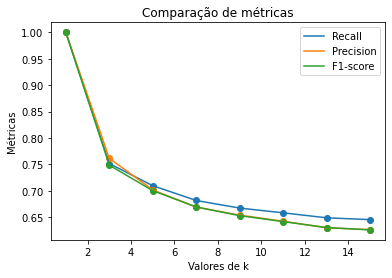

Best K: 1


,Metrics
Recall,1.0
Precision,1.0
F1-score,1.0


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,1724,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit,0,830,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Sit and Talk,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
Walk,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0
Walk and Talk,0,0,0,0,1620,0,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,78,0,0,0,0,0,0,0,0,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,76,0,0,0,0,0,0,0,0,0
Stand -> Sit,0,0,0,0,0,0,0,1561,0,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,0,2917,0,0,0,0,0,0,0
Stand -> Sit and talk,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0,0


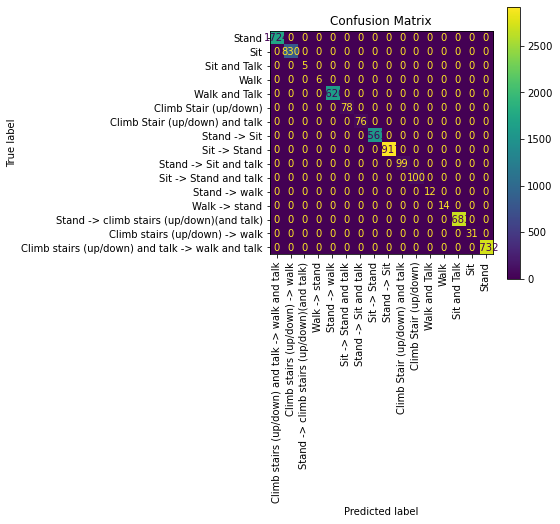

In [35]:
TO_gama(feature_data, new_target, activities)

### 3.1.2. TVT 40-30-30

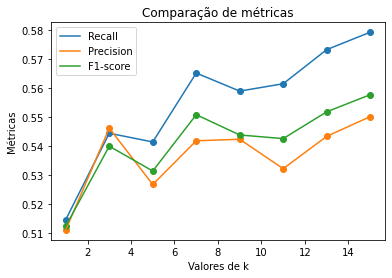

Best K: 15


,Metrics
Recall,0.571429
Precision,0.543611
F1-score,0.551989


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,245,16,0,0,0,0,0,0,0,1,0,0,141,0,110
1,99,9,0,0,0,0,0,0,0,0,0,0,68,0,78
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,322,0,0,182,3,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,13,0,0,0,0,4,0,1
5,3,0,0,0,0,0,0,12,1,0,0,0,6,0,1
6,0,0,0,133,1,1,325,11,0,0,0,0,0,0,1
7,1,0,0,3,1,0,0,839,1,0,0,0,12,0,7
8,3,1,0,7,2,0,5,2,1,0,0,0,6,0,2
9,3,0,0,3,0,0,13,5,0,0,0,0,5,0,3


In [36]:
TVT_gama(feature_data, new_target, activities)

### 3.1.2. 10x10-fold cross-validation (10CV)

------------------- Iteração 0 -------------------


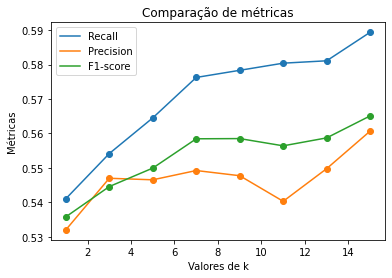

Best K: 15


,Metrics
Recall,0.589372
Precision,0.560704
F1-score,0.565110


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,87,3,0,0,0,0,0,0,0,0,0,0,0,37,0,30
Sit,39,3,0,0,0,0,0,0,0,1,0,0,0,20,0,25
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk and Talk,0,0,0,0,109,0,0,48,1,0,0,0,0,0,0,0
Climb Stair (up/down),1,0,0,0,0,1,0,0,8,0,0,0,0,1,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,0,0,2,4,0,1,0,0,0,0,0
Stand -> Sit,0,0,0,0,39,0,0,140,3,0,0,0,0,0,0,0
Sit -> Stand,0,0,0,0,0,0,0,1,276,1,0,0,0,3,0,0
Stand -> Sit and talk,1,0,0,0,2,0,1,4,0,0,0,0,0,2,0,1


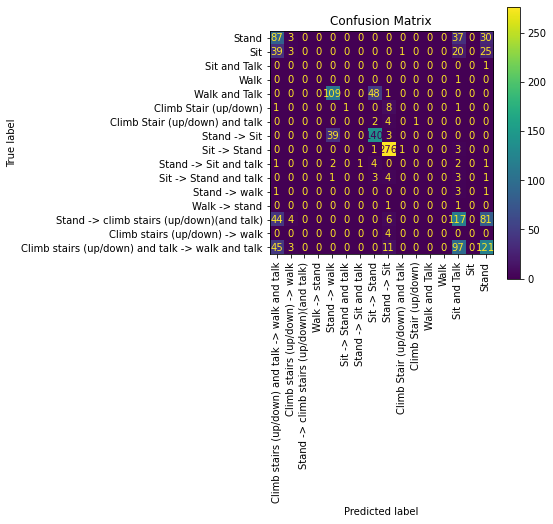

------------------- Iteração 1 -------------------


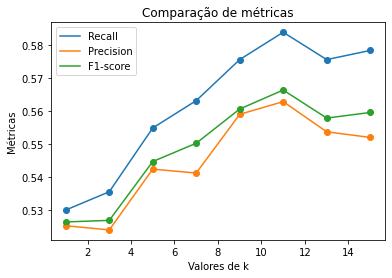

Best K: 11


,Metrics
Recall,0.583851
Precision,0.562834
F1-score,0.566348


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,90,8,0,0,0,0,0,0,0,0,0,0,60,0,44
1,32,2,0,0,0,0,0,0,0,0,0,0,23,0,21
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,118,1,0,45,0,0,0,0,0,0,0
5,1,0,0,0,0,0,1,0,6,0,0,0,3,0,0
6,0,1,0,0,0,0,0,0,3,1,0,0,0,0,0
7,0,0,0,0,39,0,0,108,1,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,265,0,0,0,3,0,1
9,0,0,0,0,1,1,1,5,1,1,0,0,4,0,3


------------------- Iteração 2 -------------------


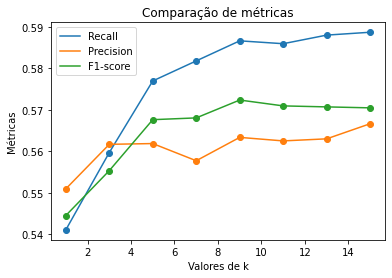

Best K: 9


,Metrics
Recall,0.586611
Precision,0.563354
F1-score,0.572351


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,82,13,0,0,0,0,0,0,0,0,0,47,0,43
1,22,6,0,1,0,0,0,0,0,0,0,26,0,25
2,0,0,106,0,0,50,2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,7,0,0,0,0,1,0,1
4,1,0,0,0,0,0,4,0,0,0,0,1,0,0
5,0,0,27,1,0,109,1,1,0,0,0,1,0,0
6,2,0,1,0,0,0,298,0,0,0,0,5,0,1
7,0,0,1,3,0,1,0,0,0,0,0,0,0,1
8,0,0,2,1,0,5,1,0,0,0,0,1,0,0
9,1,1,0,0,0,0,0,0,0,0,0,0,0,0


------------------- Iteração 3 -------------------


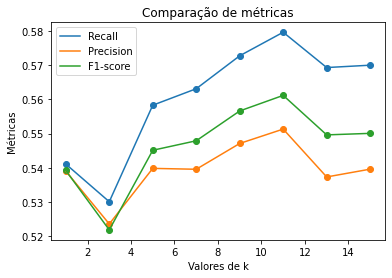

Best K: 11


,Metrics
Recall,0.579710
Precision,0.551315
F1-score,0.561197


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,57,7,0,0,0,0,0,0,0,0,0,40,0,38
1,25,5,0,0,0,0,0,0,0,0,0,28,0,20
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,133,1,0,43,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,6,0,0,0,1,0,0
5,0,0,0,0,0,0,0,5,0,0,0,2,0,1
6,0,0,0,39,0,0,123,2,0,0,0,1,0,0
7,0,0,0,0,1,0,0,281,0,0,0,5,0,0
8,0,0,0,2,2,1,2,1,0,0,0,2,0,1
9,2,1,0,2,0,0,5,2,2,0,0,3,0,1


------------------- Iteração 4 -------------------


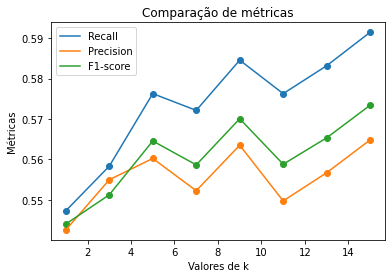

Best K: 15


,Metrics
Recall,0.591442
Precision,0.564822
F1-score,0.573398


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,72,9,0,0,0,0,0,0,0,0,0,0,45,0,39
1,35,4,0,0,0,0,0,1,0,0,0,0,29,0,27
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,95,0,0,53,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,5,1,0,0,0,1,0,0
5,0,0,0,0,0,0,0,6,0,0,0,0,0,0,1
6,0,0,0,45,0,0,114,1,2,0,0,0,0,0,0
7,1,0,0,2,0,1,1,307,0,0,0,0,6,0,1
8,0,0,0,3,0,0,4,1,0,0,0,0,1,0,1
9,0,0,0,0,0,0,1,0,0,1,0,0,2,0,0


------------------- Iteração 5 -------------------


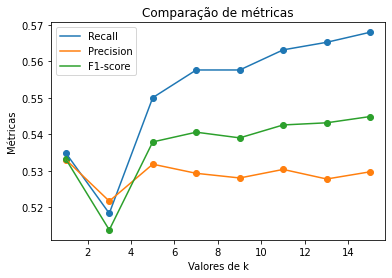

Best K: 15


,Metrics
Recall,0.567978
Precision,0.529690
F1-score,0.544850


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,79,3,0,0,0,0,0,0,0,0,0,44,0,48
1,39,1,0,0,0,0,0,0,0,0,0,27,0,20
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,115,0,0,66,0,0,0,0,0,0,0
4,3,0,0,0,0,0,0,5,0,0,0,2,0,0
5,0,0,0,0,0,0,0,4,0,0,0,1,0,0
6,0,0,0,42,0,0,106,3,0,0,0,0,0,0
7,0,0,0,0,0,0,1,253,0,0,0,1,0,1
8,0,1,0,1,1,0,0,0,0,0,0,1,0,0
9,0,2,0,2,0,0,1,1,0,0,0,2,0,2


------------------- Iteração 6 -------------------


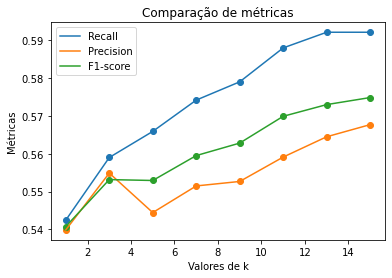

Best K: 15


,Metrics
Recall,0.592133
Precision,0.567699
F1-score,0.574860


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,83,5,0,0,0,0,0,1,0,0,52,0,35
1,39,4,0,0,0,0,0,0,0,0,23,0,23
2,0,0,103,0,0,43,1,1,0,0,0,0,0
3,0,0,0,0,0,0,2,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0
5,0,0,31,0,0,112,4,0,0,0,1,0,0
6,1,0,0,1,0,0,286,0,0,0,0,0,0
7,0,0,4,0,1,1,1,1,0,0,1,0,1
8,1,1,0,0,0,6,2,0,0,0,0,0,1
9,2,0,0,0,0,0,0,0,0,0,0,0,0


------------------- Iteração 7 -------------------


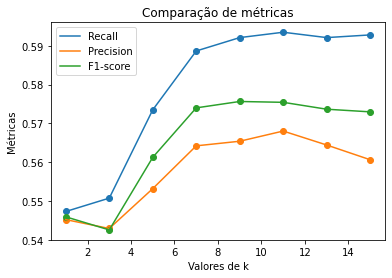

Best K: 9


,Metrics
Recall,0.592133
Precision,0.565396
F1-score,0.575651


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,76,8,0,0,0,0,1,0,0,0,51,0,44
1,26,8,0,0,0,0,0,0,0,0,23,0,23
2,0,0,115,0,0,44,0,0,1,0,0,0,0
3,0,0,0,1,0,0,2,0,1,0,0,0,1
4,1,2,0,0,0,0,6,1,0,0,2,0,0
5,0,0,48,0,0,107,2,1,0,0,0,0,0
6,0,0,1,0,0,0,304,0,0,0,2,0,1
7,1,1,1,1,0,1,1,0,1,0,2,0,0
8,2,0,0,0,0,8,3,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,2,0,0


------------------- Iteração 8 -------------------


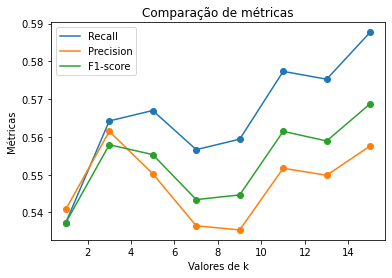

Best K: 15


,Metrics
Recall,0.587707
Precision,0.557604
F1-score,0.568778


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,79,9,0,0,0,0,0,0,0,1,0,0,0,55,0,38
Sit,31,3,0,0,0,0,0,0,0,0,0,0,0,24,0,21
Sit and Talk,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk and Talk,0,0,0,0,104,0,0,56,2,0,0,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,0,0,0,0,6,0,0,0,0,4,0,0
Climb Stair (up/down) and talk,2,0,0,0,0,0,0,0,6,2,0,0,0,3,0,0
Stand -> Sit,0,0,0,0,40,0,0,103,3,0,0,0,0,0,0,1
Sit -> Stand,0,0,0,0,2,0,0,0,291,0,0,0,0,3,0,2
Stand -> Sit and talk,0,0,0,0,1,1,0,3,3,1,0,0,0,2,0,0


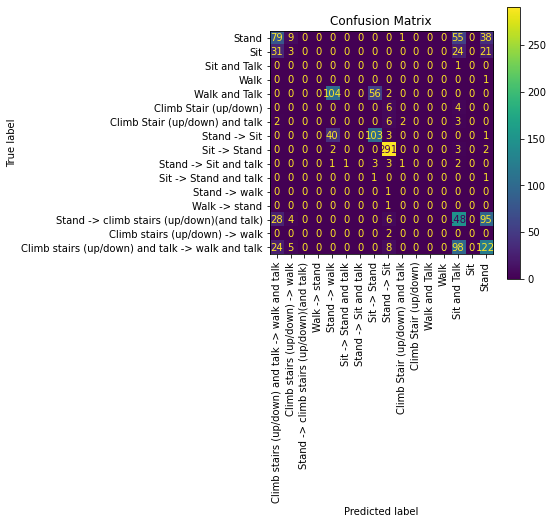

------------------- Iteração 9 -------------------


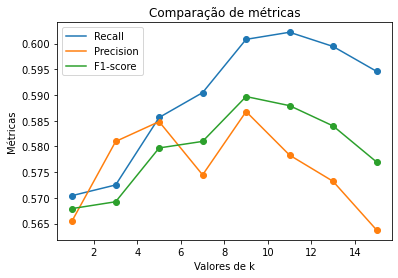

Best K: 9


,Metrics
Recall,0.600829
Precision,0.586783
F1-score,0.589703


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,81,10,0,0,0,0,0,0,0,0,0,30,0,40
1,22,5,0,0,0,0,0,0,0,0,0,27,0,21
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,122,0,0,41,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,2,0,0,0,1,0,0
5,1,0,0,0,1,1,0,4,0,0,0,3,0,2
6,0,0,0,35,0,0,123,0,1,1,0,0,0,0
7,3,0,0,0,1,0,0,295,0,0,0,3,0,1
8,1,2,0,1,0,1,2,1,1,0,0,1,0,0
9,1,0,0,0,0,0,4,3,0,0,0,3,0,0


In [37]:
CV_gama(feature_data, new_target, activities)

### 3.2. ReliefF

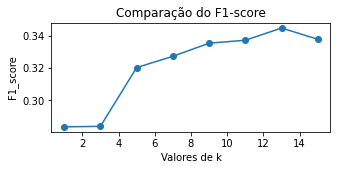

Nr of features: 1
Best K: 13
F1_score: 0.3507084839849343
--------------------------------------------------


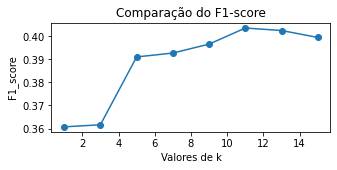

Nr of features: 2
Best K: 11
F1_score: 0.41039764216026114
--------------------------------------------------


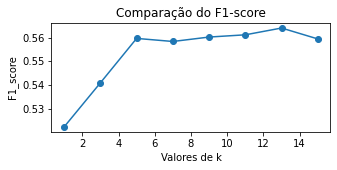

Nr of features: 3
Best K: 13
F1_score: 0.5862568729807559
--------------------------------------------------


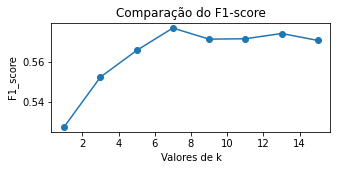

Nr of features: 4
Best K: 7
F1_score: 0.5944357320655103
--------------------------------------------------


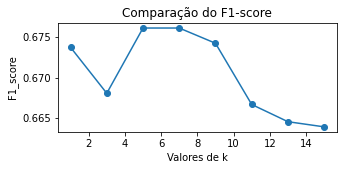

Nr of features: 5
Best K: 5
F1_score: 0.6771406994393503
--------------------------------------------------


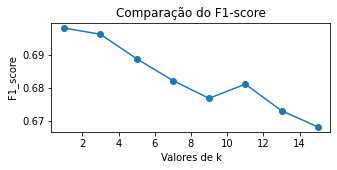

Nr of features: 6
Best K: 1
F1_score: 0.7062726542740562
--------------------------------------------------


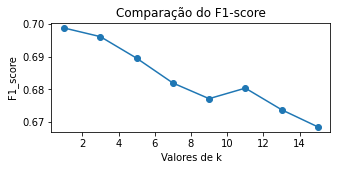

Nr of features: 7
Best K: 1
F1_score: 0.7067515633646584
--------------------------------------------------


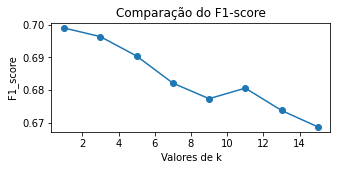

Nr of features: 8
Best K: 1
F1_score: 0.7063365570438986
--------------------------------------------------


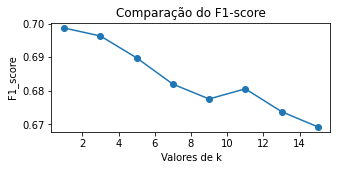

Nr of features: 9
Best K: 1
F1_score: 0.7061414834194689
--------------------------------------------------


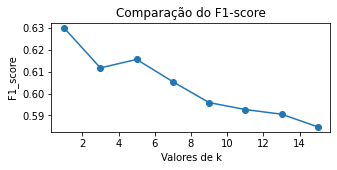

Nr of features: 10
Best K: 1
F1_score: 0.6356839640012858
--------------------------------------------------


,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.283646,0.283962,0.320314,0.327290,0.335387,0.337209,0.344772,0.337827
Nº of features: 2,0.360719,0.361621,0.391094,0.392794,0.396671,0.403661,0.402583,0.399565
Nº of features: 3,0.522240,0.540877,0.559678,0.558380,0.560253,0.561202,0.564076,0.559458
Nº of features: 4,0.527368,0.552400,0.565822,0.577111,0.571514,0.571714,0.574354,0.570876
Nº of features: 5,0.673729,0.668054,0.676109,0.676108,0.674230,0.666673,0.664546,0.663910
Nº of features: 6,0.698214,0.696324,0.688928,0.682315,0.676939,0.681233,0.673182,0.668303
Nº of features: 7,0.698732,0.696099,0.689524,0.681954,0.677175,0.680389,0.673807,0.668572
Nº of features: 8,0.698977,0.696352,0.690427,0.682157,0.677409,0.680625,0.673807,0.668810
Nº of features: 9,0.698748,0.696382,0.689853,0.682014,0.677599,0.680625,0.673807,0.669279
Nº of features: 10,0.629889,0.611689,0.615560,0.605374,0.595849,0.592675,0.590560,0.584776


In [38]:
newActivity_elbow, df3, str_print = repeatTVT(feature_data,new_target, reliefF(feature_data, new_target), 10)

### 3.2. Elbow Graph

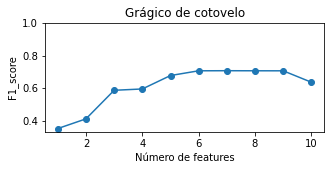

In [39]:
elbowGraph(newActivity_elbow, 11)

### 3.3. Validation set results

In [40]:
display(df3)

,k=1,k=3,k=5,k=7,k=9,k=11,k=13,k=15
Nº of features: 1,0.283646,0.283962,0.320314,0.327290,0.335387,0.337209,0.344772,0.337827
Nº of features: 2,0.360719,0.361621,0.391094,0.392794,0.396671,0.403661,0.402583,0.399565
Nº of features: 3,0.522240,0.540877,0.559678,0.558380,0.560253,0.561202,0.564076,0.559458
Nº of features: 4,0.527368,0.552400,0.565822,0.577111,0.571514,0.571714,0.574354,0.570876
Nº of features: 5,0.673729,0.668054,0.676109,0.676108,0.674230,0.666673,0.664546,0.663910
Nº of features: 6,0.698214,0.696324,0.688928,0.682315,0.676939,0.681233,0.673182,0.668303
Nº of features: 7,0.698732,0.696099,0.689524,0.681954,0.677175,0.680389,0.673807,0.668572
Nº of features: 8,0.698977,0.696352,0.690427,0.682157,0.677409,0.680625,0.673807,0.668810
Nº of features: 9,0.698748,0.696382,0.689853,0.682014,0.677599,0.680625,0.673807,0.669279
Nº of features: 10,0.629889,0.611689,0.615560,0.605374,0.595849,0.592675,0.590560,0.584776


### 3.4. Test set results

In [41]:
print(str_print)

Nr of features: 1
Best K: 13
F1_score: 0.3507084839849343
--------------------------------------------------
Nr of features: 2
Best K: 11
F1_score: 0.41039764216026114
--------------------------------------------------
Nr of features: 3
Best K: 13
F1_score: 0.5862568729807559
--------------------------------------------------
Nr of features: 4
Best K: 7
F1_score: 0.5944357320655103
--------------------------------------------------
Nr of features: 5
Best K: 5
F1_score: 0.6771406994393503
--------------------------------------------------
Nr of features: 6
Best K: 1
F1_score: 0.7062726542740562
--------------------------------------------------
Nr of features: 7
Best K: 1
F1_score: 0.7067515633646584
--------------------------------------------------
Nr of features: 8
Best K: 1
F1_score: 0.7063365570438986
--------------------------------------------------
Nr of features: 9
Best K: 1
F1_score: 0.7061414834194689
--------------------------------------------------
Nr of features: 10
Best 

### 4. Neural net

In [42]:
from sklearn.neural_network import MLPClassifier

dataTVT = train_validation_test(feature_data, new_target, 0.4, 0.3)

def plot_f1(metr, neur_evol):
    plt.figure()

    plt.plot(neur_evol, metr, label="f1")
    plt.scatter(neur_evol, metr)
    
    plt.title("Evolução do f1-score")
    plt.xlabel("Número de neurónios")
    plt.ylabel("f1-score")
    plt.show()

### 4.1. Fixed learning speed

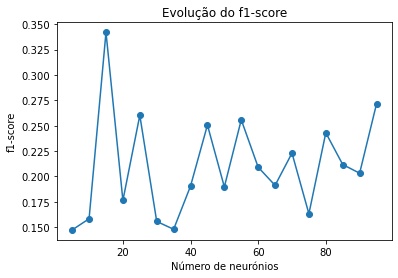

Best neurons number: 15


,Metrics
Recall,0.675638
Precision,0.671876
F1-score,0.673332


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,353,135,0,0,1,1,1,0,2,0,0,0,0,25,0,27
Sit,126,85,0,0,1,1,0,1,2,1,2,0,0,10,0,11
Sit and Talk,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Walk and Talk,0,0,0,0,368,0,0,97,6,3,5,0,0,0,0,0
Climb Stair (up/down),0,0,0,0,2,3,2,0,10,0,1,0,0,2,0,0
Climb Stair (up/down) and talk,0,0,0,0,0,1,6,0,11,2,0,0,0,2,0,0
Stand -> Sit,0,1,0,0,82,0,0,345,3,2,7,0,0,3,0,0
Sit -> Stand,2,2,0,0,1,10,2,0,817,1,0,0,0,25,0,22
Stand -> Sit and talk,0,0,0,0,5,2,1,9,1,5,8,0,0,0,0,0


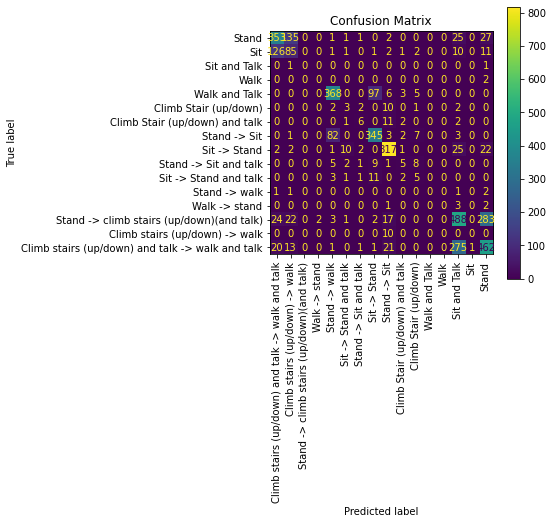

In [43]:
from sklearn.preprocessing import StandardScaler  

def mlp_4(type_speed):
    nns = []
    metrF1 = []

    scaler = StandardScaler() 
    scaler.fit(dataTVT["TRAIN"][0])
    dataTVT["TRAIN"][0] = scaler.transform(dataTVT["TRAIN"][0]) 
    dataTVT["TEST"][0] = scaler.transform(dataTVT["TEST"][0])  
    neur_evol = np.arange(5, 100, 5)

    for i in neur_evol:
        if type_speed == 'fixed':
            clf = MLPClassifier(activation='logistic', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=i, max_iter=2000)
        elif type_speed == 'variable':
            clf = MLPClassifier(activation='logistic', learning_rate='invscaling', solver='sgd', learning_rate_init=0.1, hidden_layer_sizes=i, max_iter=2000)
        else:
             clf = MLPClassifier(activation='logistic', hidden_layer_sizes=i, solver='sgd', learning_rate_init=0.1, momentum=0.5, max_iter=2000)
        
        nns.append(clf.fit(dataTVT["TRAIN"][0], dataTVT["TRAIN"][1]))

        pred = clf.predict(dataTVT["VALIDATION"][0])

        true = dataTVT['VALIDATION'][1]
        
        cm, rs, ps, f1 = metrics(true, pred)

        metrF1.append(f1)

    plot_f1(metrF1, neur_evol)

    print("Best neurons number: " + str(neur_evol[np.argmax(metrF1)]))

    best_nns = nns[np.argmax(metrF1)]
    pred = best_nns.predict(dataTVT["TEST"][0])
    true = dataTVT['TEST'][1]
    cm, rs, ps, f1 = metrics(true, pred)
    mais_bonito(cm, rs, ps, f1, activities)

mlp_4('fixed')


### 4.2. Variable learning speed

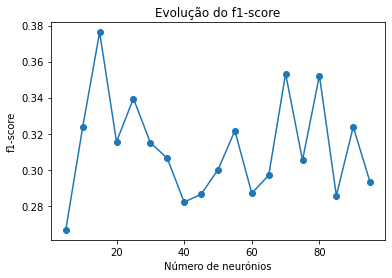

Best neurons number: 15


,Metrics
Recall,0.616747
Precision,0.561456
F1-score,0.575434


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,434,0,0,0,0,0,0,0,0,0,0,0,0,74,0,37
Sit,195,0,0,0,0,0,0,0,0,0,0,0,0,25,0,20
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Walk and Talk,0,0,0,0,416,0,0,63,0,0,0,0,0,0,0,0
Climb Stair (up/down),2,0,0,0,0,0,0,1,15,0,0,0,0,2,0,0
Climb Stair (up/down) and talk,3,0,0,0,0,0,0,1,15,0,0,0,0,3,0,0
Stand -> Sit,0,0,0,0,335,0,0,108,0,0,0,0,0,0,0,0
Sit -> Stand,1,0,0,0,0,0,0,4,867,0,0,0,0,9,0,1
Stand -> Sit and talk,6,0,0,0,6,0,0,17,0,0,0,0,0,0,0,2


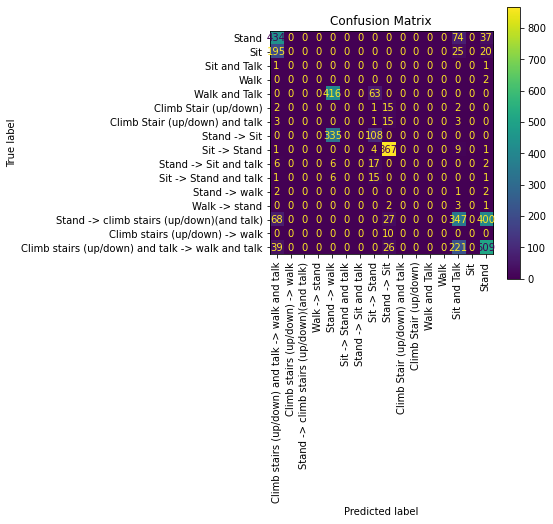

In [44]:
mlp_4('variable')

### 4.3. Momentum coeficient

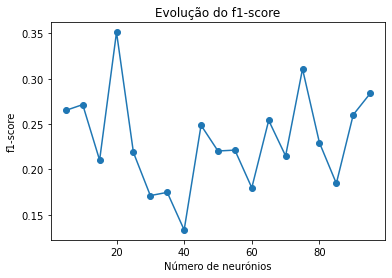

Best neurons number: 20


,Metrics
Recall,0.685760
Precision,0.679682
F1-score,0.682236


,Stand,Sit,Sit and Talk,Walk,Walk and Talk,Climb Stair (up/down),Climb Stair (up/down) and talk,Stand -> Sit,Sit -> Stand,Stand -> Sit and talk,Sit -> Stand and talk,Stand -> walk,Walk -> stand,Stand -> climb stairs (up/down)(and talk),Climb stairs (up/down) -> walk,Climb stairs (up/down) and talk -> walk and talk
Stand,359,125,0,0,1,0,0,1,2,0,0,1,0,34,0,22
Sit,126,87,0,0,0,0,0,0,0,0,1,0,0,15,0,11
Sit and Talk,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
Walk,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
Walk and Talk,0,0,0,0,382,0,0,95,1,1,0,0,0,0,0,0
Climb Stair (up/down),2,0,0,0,0,1,3,0,11,0,0,0,0,2,0,1
Climb Stair (up/down) and talk,1,1,0,0,0,2,3,2,7,0,2,0,0,3,0,1
Stand -> Sit,0,0,0,0,68,0,0,362,1,8,2,0,0,0,0,2
Sit -> Stand,5,2,0,0,1,9,3,6,808,1,0,0,0,28,0,19
Stand -> Sit and talk,0,2,0,0,6,2,0,6,1,3,9,0,0,1,0,1


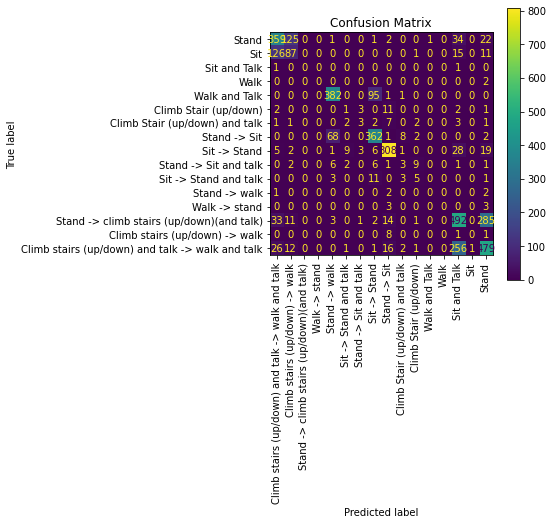

In [45]:
mlp_4('momentum')

### 5. Neural net from scratch

In [46]:
def feedforward(entrada, weights1, weights2):
    layer1 = sigmoid(np.dot(entrada, weights1))
    saida = sigmoid(np.dot(layer1, weights2))
    return layer1, saida

def backprop(entrada, target, saida, weights1, weights2, layer1):
    # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
    d_weights2 = np.dot(layer1.T, (2*(target - saida) * sigmoid_derivative(saida)))
    d_weights1 = np.dot(entrada.T,  (np.dot(2*(target - saida) * sigmoid_derivative(saida), weights2.T) * sigmoid_derivative(layer1)))

    # update the weights with the derivative (slope) of the loss function
    weights1 += d_weights1
    weights2 += d_weights2

    return weights1, weights2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

for i in 

entrada = 
weights1 = np.random.rand(input.shape[1],4) 
weights2 = np.random.rand(4,1)                 
y = y
output = np.zeros(y.shape)